In [1]:
%run ../widgets/config_check.py

sys:1: UserWarning: Your current version of bqplot (0.10.5) is older then the one used in tests (0.11). It is recommended to uprgade it.


In [2]:
# <api>
import numpy as np
from scipy.stats import norm, multivariate_normal
from matplotlib import pyplot as plt
%matplotlib inline

# Load classes and functions from the previous parts
from jupyter_cms.loader import load_notebook
smpl_intro = load_notebook('./Sampling_Intro.ipynb')
smpl_rej = load_notebook('./Sampling_Rejection.ipynb')

# Importance sampling

Importance sampling tries to fix the inefficiency of rejection sampling, by assigning weights to each sample instead of rejecting. It is based on the observation that
$$ \mathbb{E}_p[f] = \int f(x) p(x) dx = \int f(x) \frac{p(x)}{q(x)} q(x) dx = \mathbb{E}_q[f \frac{p}{q}] $$
for any function $f(x)$.

Thus, instead of using samples $x_1,\ldots,x_N$ from $p(x)$ to approximate the expectation $\mathbb{E}_p[f]$ of $f$ under $p$ as
$$ \mathbb{E}_p[f] \approx \frac{1}{N} \sum_{i=1}^n f(x_i) $$
we can just as well use samples from some other distribution $q(x)$ and evaluate the expectation of $f \frac{p}{q}$ under $q$.

This scheme can easily be extended when the normalization constant of $p(x)$ is not available, i.e. $p(x) = \frac{1}{Z} \hat{p}(x)$. Then,
$$ \mathbb{E}_p[f] = \int \frac{1}{Z} f(x) \hat{p}(x) dx = \frac{1}{Z} \mathbb{E}_q[f \frac{\hat{p}}{q}] $$
and since $\int p(x) dx = 1 = \frac{1}{Z} \int \frac{\hat{p}(x)}{q(x)} q(x) dx$, $Z$ can be found via importance sampling as well:
$$ Z = \int \frac{\hat{p}(x)}{q(x)} q(x) dx = \mathbb{E}_q[\frac{\hat{p}}{q}]$$

Thus, assuming that we have samples $x_1,\ldots,x_n$ from $q$, the expectation $\mathbb{E}_p[f]$ can be approximated as
$$ \mathbb{E}_p[f] \approx \frac{\sum_{i=1}^N f(x_i) w_i}{\sum_{i=1}^N w_i} $$
with $w_i = \frac{\hat{p}(x_i)}{q(x_i)}$ being the **_weight_** of sample $x_i$

In [3]:
# <api>
class ImportanceSampling (smpl_intro.Sampling):
    def __init__(self, log_p, q):
        """
        q is assumed to support sampling q.rvs and density evaluation q.pdf
        """
        self.log_p = log_p
        self.q = q
        
    def sample (self):
        """
        Note: Importance sampling returns a sample and its associated weight
        """
        x = self.q.rvs()
        w = np.exp(self.log_p(x) - self.q.logpdf(x))
        return [x,w]

In [4]:
# <api>
def weighted_gauss_hist (ax, weighted_data, bins):
    x = np.arange(-4,4,0.01)
    ax.hist(np.array(weighted_data)[:,0], bins, normed=True, 
            weights=np.array(weighted_data)[:,1])
    ax.plot(x, smpl_intro.phi(x), 'r-', alpha=0.7)

In [5]:
sampling = ImportanceSampling(log_p=lambda x: np.log(smpl_rej.p(x)), q=norm(loc=1,scale=2))

smpl_intro.show_sampling(sampling, plotter=weighted_gauss_hist, 
                    f_exp=lambda x: np.array(x[0])[:,1], true_exp=np.sqrt(2*np.pi))

Output()

We can also approximate the normalization constant of $p(x) = e^{-\frac{1}{2} x^2}$ by the mean of the sample weights:

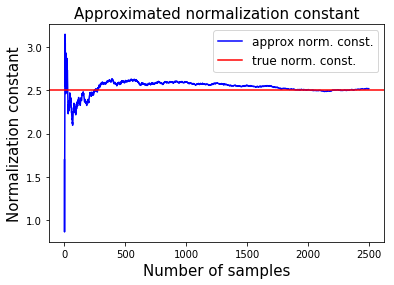

In [6]:
smpl_intro.show_expectation(sampling, lambda x: x[1]) # f extracts weight
plt.axhline(np.sqrt(2*np.pi), color='r') # true normalization constant
plt.legend(['approx norm. const.', 'true norm. const.'], fontsize=12)
plt.xlabel('Number of samples', fontsize=15)
plt.ylabel('Normalization constant', fontsize=15)
plt.title('Approximated normalization constant', fontsize=15);

Importance sampling can fail miserably if $q$ has thinner tails than $p$. In this case, the weights $\frac{p(x)}{q(x)}$ can become arbitrarily large and dominate the weighted samples!

This effect is demonstrated below:

In [7]:
sampling = ImportanceSampling(log_p=lambda x: np.log(smpl_rej.p(x)), q=norm(loc=0,scale=0.25))

smpl_intro.show_sampling(sampling, plotter=weighted_gauss_hist, f_exp=lambda x: np.array(x[0])[:,1])

Output()

Is there a diagnostic to detect this type of problem?

In general, detecting the failure of a sampling methods can be quite difficult. Nevertheless the importance weights can give us some information about the effectiveness of importance sampling. We noted above, that the variance of the standard Monte-Carlo estimate using $N$ samples is given by
$$ \mathbb{V}ar_p[\frac{1}{N} \sum_{i=1}^N f(x_i)] = \frac{1}{N} \mathbb{V}ar_p[f] $$
Similarly, we could compute the variance of the weighted average used in importance sampling
$$ \mathbb{V}ar_p[\sum_{i=1}^N \frac{w_i}{\sum_{i=1}^N w_i} f(x_i)] = \frac{\sum_{i=1}^N w_i^2}{(\sum_{i=1}^N w_i)^2} \mathbb{V}ar_p[f] $$
Thus, by comparing coefficients we can define
$$ N_{eff} = \frac{(\sum_{i=1}^N w_i)^2}{\sum_{i=1}^N w_i^2} $$
as an approximate effective sampling size.

Note: This derivation is by no means exact, as the weights $w_i$ are actually not fixed, but dependent on the samples $x_i$. Thus, they are in particular not necessarily independent of $f(x_i)$ ...

In [8]:
# <api>
def ess (x):
    """
    Effective sample size of weighted samples x
    """
    w = np.array(x)[:,1] # extract weight
    return np.sum(w)**2/np.sum(w**2)

In [9]:
# <api>
def plt_ess (ax, weighted_data, bins):
    weighted_gauss_hist(ax, weighted_data, bins)    
    ax.text(1, 0.35, "N_eff = "+str(ess(weighted_data)))

In [10]:
smpl_intro.show_sampling(sampling, plotter=plt_ess, f_exp=lambda x: np.array(x[0])[:,1])

Output()

Some theoretical remarks on importance sampling:

* What is the optimal choice for $q$?

  Remember that the variance of a Monte-Carlo estimate for $\mu = \mathbb{E}_p[f]$ is given by $\frac{1}{N} \mathbb{V}ar_p[f]$. In importance sampling, the integrand is changed to $f \frac{p}{q}$ and the expectation is then evaluated with respect to the sampling density $q$. It is easy to see that the optimal choice would be $q(x) = \frac{p(x) f(x)}{\mu}$ with variance
  $$ \mathbb{V}ar_q[ f \frac{p}{q} ] = \mathbb{V}ar_q[ \mu ] = 0 $$
  Note: While optimal this choice is infeasible since the normalization constant of this $q$ is equal to $\mu$, i.e. the mean of $f$ which is to be computed in the first place.

* In general, importance sampling can be considered a variance reduction technique. We compute $$ \mathbb{V}ar_p[f] - \mathbb{V}ar_q[f \frac{p}{q}] = \int f^2(x) (1 - \frac{p(x)}{q(x)}) p(x) dx $$
  Thus, importance sampling reduces the variances when $\frac{p(x)}{q(x)} < 1$ if $f(x) p(x)$ large, while allowing for $\frac{p(x)}{q(x)} > 1$ if $f(x) p(x)$ is small.

**Example**: Pricing an (out-of-the-money) Asian call option with importance sampling

A (European) call option gives the buyer (of the option) the right to buy the underlying stock at a specified future time, the options expiration date $T$, for a specified price, the options strike $K$. The expiration date and strike of a call option are fixed up front and agreed upon with the option seller. Thus, denoting the stock price at time $T$ as $S_T$, the value of a call option at expiration is given by
$$ c(S_T) = \max( 0, S_T - K ) . $$
To see this, consider two cases:

* The stock price $S_T$ is below the strike price $K$. In this case, it would be cheaper to buy the stock directly from the market instead of paying the strike price $K$. Since the option gives the right, but no obligation to buy, its value is zero as the option holder would not want to exercise her right.

* The stock price $S_T$ is above the strike price $K$. Now, it is better to buy the stock at the agreed strike price $K$. Then, immediately selling it in the market a profit of $S_T - K$ is obtained.

An Asian option is an example of a more complex, so called *exotic derivative* contract. In this case, the value of an Asian call with strike $K$ and expiration date $T$ is given by
$$ a(S_T) = \max ( 0, \frac{1}{M} \sum_{i=1}^M S_{i \frac{T}{M}} - K ), $$
i.e. the stock price is averaged over several dates $i \frac{T}{M}$ for $i=1,\ldots,M$ and then compared with the strike $K$.

According to the theory of no-arbitrage pricing, under some assumptions the current price of a derivative contract, i.e. at some time $t$ before expiration $T$, can be computed as an expectation
$$ \mathbb{E}^Q[ e^{-r (T - t)} a(S_T) ] . $$
Here, the expectation is taken with respect to the so called *risk-neutral* measure which adjusts the stock price such that it is a Martingale if discounted at the risk-less interest rate $r$, i.e. $S_t = \mathbb{E}^Q[ e^{-r (T - t)} S_T ]$.

The simplest model proposed by Black, Scholes and Merton, where these assumptions hold, assumes that stock prices $S_t$ follow a geometric Brownian motion under the risk-neutral measure, i.e. $$ S_t = S_0 e^{(r - \frac{\sigma^2}{2}) t + \sigma W_t}$$ where $W_t$ denotes a Brownian motion. A Brownian motion has the property that its increments $W_{t'} - W_t$ for $t' > t$ are

* Gaussian distributed with mean zero and variance $t' - t$.

* independent for non-overlapping intervals.

Using the above formula for the stock price, we can compute $S_{i \frac{T}{M}} = S_0 e^{(r - \frac{\sigma^2}{2}) i \frac{T}{M} + \sigma \sqrt{\frac{T}{M}} (X_1 + \ldots + X_i)}$ where $X_i \sim \mathcal{N}(0,1)$ since the Brownian motion is the cumulative sum of standard normal increments.

Below, we compute the price for an option that is vastly *out of the money*, i.e. $K \gg S_0$. In this case, the option will be almost worthless as it is unlikely that the average stock price rises above the strike.

In [11]:
# <api>
def stock_price (S_0, r, sigma, T, X):
    """
    Stock prices S_{i\frac{T}{M}} given a sequence X[1], ..., X[M] of normal increments
    """
    M = X.size
    i = np.arange(M) + 1 # i = 1,...,M
    return S_0*np.exp( (r-sigma**2/2.0)*i*T/M + sigma*np.sqrt(T/M)*np.cumsum(X) )

def a(S, K):
    return np.max([0, np.mean(S) - K])

class NormalIncrements (smpl_intro.Sampling):
    def __init__ (self, M):
        self.M = M
    def sample(self):
        return np.random.normal(size=(self.M,))
    
def out_of_money (X):
    sigma = 0.25/np.sqrt(365) # 25% yearly volatility
    S = stock_price(100, 0, sigma, 6*30, X)
    return a(S, 130)

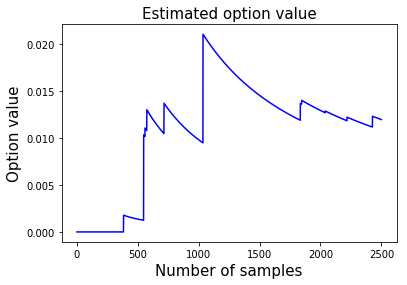

In [12]:
M = 100
smpl_intro.show_expectation(NormalIncrements(M), out_of_money)
plt.xlabel('Number of samples', fontsize=15)
plt.ylabel('Option value', fontsize=15)
plt.title('Estimated option value', fontsize=15);

The estimate is very unreliable, as most sampled stock prices are below the strike of the option and the value of the option is zero in this case. Thus, only the few cases where the stock price happened to be high enough, information about the option value is obtained.

Next, the same with importance sampling shifting up the mean of the sampling distribution:

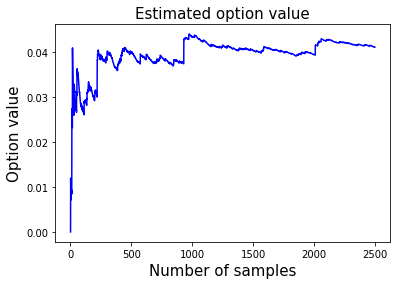

In [13]:
smpl_intro.show_expectation(ImportanceSampling(log_p = multivariate_normal(mean=np.zeros(10)).logpdf,
                                          q = multivariate_normal(mean=1.0*np.ones(10))), 
                       lambda X: X[1]*out_of_money(X[0]))
plt.xlabel('Number of samples', fontsize=15)
plt.ylabel('Option value', fontsize=15)
plt.title('Estimated option value', fontsize=15);

Importance sampling gives much more reliable estimates by focusing on stock prices which are high enough such that the option has a positive value. Thereby many more samples are produced which actually provide information about the value of the option.